In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

In [ ]:
# Config
INPUT_DIR = Path("./output_wav2vec_precomputed_features")
OUTPUT_DIR = Path("./output_1d_cnn_5_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 
EPOCHS = 50
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_1d_cnn_5_class_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\n--- Loading and modifying pre-computed data... ---")

# Load the compressed .npz files directly into RAM
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

X_train, y_train_full = train_data['x'], train_data['y']
X_val, y_val_full = val_data['x'], val_data['y']
X_test, y_test_full = test_data['x'], test_data['y']

# Remove the last column ('NoStutter') from the labels
y_train = y_train_full[:, :-1]
y_val = y_val_full[:, :-1]
y_test = y_test_full[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

In [13]:
print("\n--- Verifying final training set distribution after augmentation... ---")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


--- Verifying final training set distribution after augmentation... ---
Final distribution of labels in the training set (including augmented samples):
Block           12026
Interjection     9173
WordRep          8256
SoundRep         7776
Prolongation     7501
dtype: int64


In [ ]:
print("\n--- Building tf.data pipeline... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")

In [ ]:

with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,677 (1.64 MB)

 Trainable params: 427,909 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/50


I0000 00:00:1753100319.757993    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14725743231753044487
I0000 00:00:1753100320.351166    4694 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3504802633909220864), session_name()
I0000 00:00:1753100322.822454    4694 tpu_compile_op_common.cc:245] Compilation of 3504802633909220864 with session name  took 2.471107774s and succeeded
I0000 00:00:1753100322.833552    4694 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3504802633909220864), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14725743231753044487", property.function_library_fingerprint = 4751289454997683265, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2570 - auc: 0.6084 - loss: 0.6619 - precision: 0.4950 - recall: 0.5685

I0000 00:00:1753100328.492587    4664 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14621082635306602869), session_name()
I0000 00:00:1753100331.295450    4664 tpu_compile_op_common.cc:245] Compilation of 14621082635306602869 with session name  took 2.802811097s and succeeded
I0000 00:00:1753100331.306600    4664 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14621082635306602869), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14725743231753044487", property.function_library_fingerprint = 4751289454997683265, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,150,768,;7,5,;", property.guaranteed_constants_size = 0, embedding_p

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2571 - auc: 0.6088 - loss: 0.6616 - precision: 0.4954 - recall: 0.5678

I0000 00:00:1753100344.770110    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:3563049609768134457
I0000 00:00:1753100345.137491    4665 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16473703027479722974), session_name()
I0000 00:00:1753100345.926145    4665 tpu_compile_op_common.cc:245] Compilation of 16473703027479722974 with session name  took 788.59318ms and succeeded
I0000 00:00:1753100345.929985    4665 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16473703027479722974), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_3563049609768134457", property.function_library_fingerprint = 7870048755608480932, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z


Epoch 1: val_auc improved from -inf to 0.67060, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.2572 - auc: 0.6090 - loss: 0.6615 - precision: 0.4956 - recall: 0.5676 - val_accuracy: 0.2366 - val_auc: 0.6706 - val_loss: 0.6451 - val_precision: 0.5694 - val_recall: 0.4461
Epoch 2/50
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3081 - auc: 0.6799 - loss: 0.6122 - precision: 0.5957 - recall: 0.5100
Epoch 2: val_auc improved from 0.67060 to 0.70226, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.3082 - auc: 0.6800 - loss: 0.6121 - precision: 0.5958 - recall: 0.5100 - val_accuracy: 0.2192 - val_auc: 0.7023 - val_loss: 0.6443 - val_precision: 0.5237 - val_recall: 0.5169
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3145 - auc: 0.7035 - loss: 0.5990 - precision: 0.6264 - recall: 0.5187



--- Evaluating Model on the Test Set ---


I0000 00:00:1753100882.723564    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14168895439791745766
E0000 00:00:1753100882.733558    3938 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753100882.772372    4726 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3955853719832996069), session_name()
I0000 00:00:1753100883.031795    4726 tpu_compile_op_common.cc:245] Compilation of 3955853719832996069 with session name  took 259.353448ms and succeeded
I0000 00:00:1753100883.032985    4726 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3955853719832996069), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14168895439791745766", property.function_library_fingerprint = 10667233458004801588, property.mlir_mo

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

I0000 00:00:1753100887.647196    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12140649142079556011
I0000 00:00:1753100887.840760    4666 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18164971116944237923), session_name()
I0000 00:00:1753100888.312018    4666 tpu_compile_op_common.cc:245] Compilation of 18164971116944237923 with session name  took 471.212601ms and succeeded
I0000 00:00:1753100888.312792    4666 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18164971116944237923), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12140649142079556011", property.function_library_fingerprint = 303911995334612792, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, top

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.84      0.21      0.34      2613
       Block       0.62      0.44      0.51      3501
    SoundRep       0.65      0.37      0.47      1891
     WordRep       0.38      0.79      0.51      1742
Interjection       0.71      0.80      0.75      3344

   micro avg       0.59      0.52      0.55     13091
   macro avg       0.64      0.52      0.52     13091
weighted avg       0.66      0.52      0.53     13091
 samples avg       0.56      0.53      0.51     13091


--- Generating plots for model training history... ---


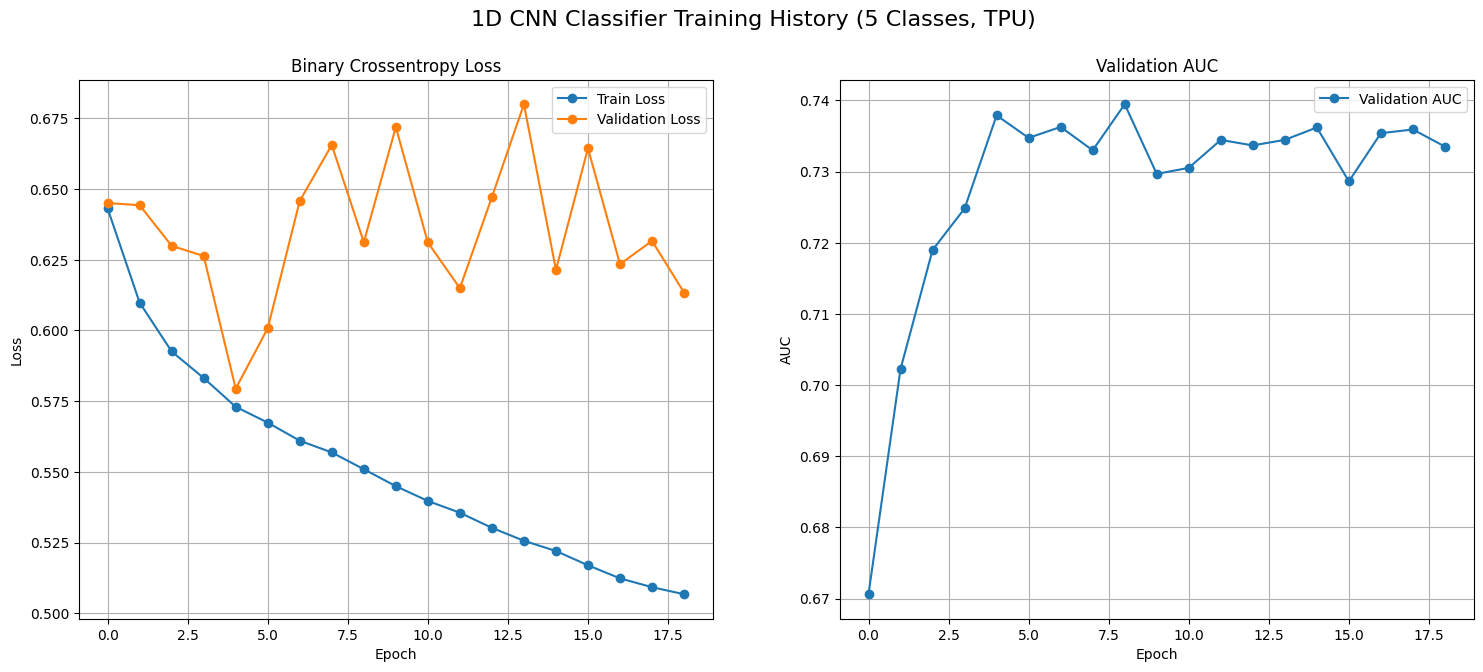


--- Pipeline complete. All outputs saved in 'output_1d_cnn_5_class_tpu' directory. ---


In [ ]:

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")